In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
path = '/disk1/hrb/python/'
obj = 'qsos'
ID = 'uid'

Query used to obtain data (context = DR16):

In [21]:
datatype = {'uid': np.uint32,   'objID'  : np.uint64, 
            'ra' : np.float128, 'ra_ref' : np.float128,
            'dec': np.float128, 'dec_ref': np.float128,
            'get_nearby_distance': np.float64}

sdss_data = pd.read_csv(path + 'data/retrieved_data/dr14q_nearby_3arcsec_class.csv', dtype = datatype, float_precision = 'round trip')

In [22]:
print('shape:',sdss_data.shape)
sdss_data.head()

shape: (525676, 8)


,uid,objID,ra,dec,ra_ref,dec_ref,class,get_nearby_distance
0,1,1237678601842131080,0.001898,17.773739,0.001898,17.773740,QSO,1.576124e-05
1,2,1237678663034601961,0.002375,5.941903,0.002375,5.941903,QSO,6.527728e-06
2,3,1237656495650570598,0.002756,14.974675,0.002756,14.974680,QSO,1.843779e-05
3,4,1237678777404358776,0.004052,4.829781,0.004052,4.829781,QSO,9.650179e-07
4,5,1237666308022010256,0.005026,24.065163,0.005026,24.065160,QSO,7.748738e-06


<AxesSubplot:>

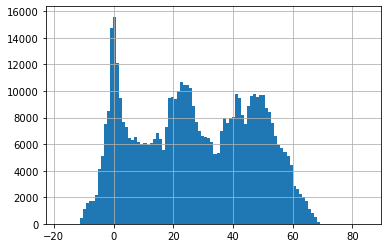

In [65]:
sdss_data['dec'].hist(bins=100)

In [23]:
#For some reason, duplicate rows are returned. Drop these.
sdss_data.drop_duplicates(subset = ['ra','dec'], keep = 'first', inplace = True)
sdss_data.sort_values('get_nearby_distance',inplace = True)
assert sdss_data['objID'].is_unique, 'objID is not unique'

In [24]:
mask = sdss_data.duplicated(subset = 'uid',keep = 'first')
sdss_qso = sdss_data[~mask]
sdss_nb  = sdss_data[mask][['uid','objID','ra','dec','class','get_nearby_distance']]
#removes other, further, neighbours
sdss_nb.drop_duplicates(subset = 'uid',inplace = True)
merged = pd.merge(sdss_qso,sdss_nb, on = 'uid', how = 'left', suffixes = ('','_nb'))
#Keep objects that have class == QSO or have <0.3" sep to reference coords (0.3" and 1" give the same thing - sanity check)
merged = merged[(merged['class'] == 'QSO') | (merged['get_nearby_distance'] < 0.005)]
merged.head()
#Merged is a table containing the matched objects and their closest neighbour (if there is one within 3", o/w NaN)

#WARNING
# Class  | number | % of total
# ----------------------------
# QSO    | 524111 | 99.73093573
# Galaxy | 1173   | 0.22320537
# Star   | 241    | 0.0458589
# Total  | 525525 | 1

,uid,objID,ra,dec,ra_ref,dec_ref,class,get_nearby_distance,objID_nb,ra_nb,dec_nb,class_nb,get_nearby_distance_nb
0,44979,1237657066329407639,17.004847,-2.496444,17.004850,-2.496444,QSO,1.659130e-09,NaN,NaN,NaN,NaN,NaN
1,1243,1237678619565555830,0.489339,3.029907,0.489339,3.029907,QSO,1.163616e-08,NaN,NaN,NaN,NaN,NaN
2,305,1237669516368150897,0.109669,6.266202,0.109669,6.266202,QSO,1.191645e-08,NaN,NaN,NaN,NaN,NaN
3,1930,1237663277928088243,0.766056,0.579586,0.766056,0.579586,QSO,4.109011e-08,NaN,NaN,NaN,NaN,NaN
4,310,1237657190905282924,0.111075,-0.196565,0.111075,-0.196565,QSO,4.180911e-08,NaN,NaN,NaN,NaN,NaN


In [25]:
#Merge sdss qsos with our original dr14q list
dr14q_coords = pd.read_csv(path + 'data/catalogues/qsos/dr14q/dr14q_uid_coords.csv', dtype = {'ra': np.float128, 'dec': np.float128, 'uid': np.uint64})
merged.sort_values('uid',inplace = True)

new_search = merged[['uid','class','get_nearby_distance_nb']]
new_search_dr14q = pd.merge(dr14q_coords, new_search, how = 'left', on = 'uid')
new_search_dr14q = new_search_dr14q.fillna(0.05)
new_search_dr14q['get_nearby_distance_nb'] += -0.01
new_search_dr14q = new_search_dr14q.rename(columns={'get_nearby_distance_nb': 'sep'})

#We join the upper search limit onto our original dr14q_coords list to prevent getting neighbours.
#Save this as dr14q_coords_unique.csv
drqsdss = pd.merge(dr14q_coords, merged[['uid','objID','class']], how = 'left', on = 'uid')
drqsdss.fillna(0.0, inplace = True)
drqsdss = drqsdss.astype({'objID': 'int64'})
# drqsdss.to_csv(path + 'coords/dr14q_coords_unique.csv', index = False)

In [26]:
sdss_dr14q_filtered = merged[['uid','objID','ra_ref','dec_ref','get_nearby_distance_nb']]
sdss_dr14q_filtered = sdss_dr14q_filtered.fillna(0.05)
sdss_dr14q_filtered['get_nearby_distance_nb'] += -0.01 # subtract a small amount from the upper search radius to prevent picking neighbours.
#remove 4 qsos because they don't match up

In [28]:
sdss_dr14q_filtered.to_csv(path + 'data/catalogues/qsos/dr14q/sdss_secondary_search_coords.csv', index = False)
sdss_dr14q_filtered

,uid,objID,ra_ref,dec_ref,get_nearby_distance_nb
30555,1,1237678601842131080,0.001898,17.773740,0.04
10747,2,1237678663034601961,0.002375,5.941903,0.04
35634,3,1237656495650570598,0.002756,14.974680,0.04
706,4,1237678777404358776,0.004052,4.829781,0.04
13477,5,1237666308022010256,0.005026,24.065160,0.04
...,...,...,...,...,...
242486,526352,1237663233915355603,359.999100,28.954730,0.04
380577,526353,1237663235523478042,359.999300,34.720840,0.04
495607,526354,1237678598090457176,359.999600,3.268586,0.04
281131,526355,1237680247351279916,359.999800,20.721080,0.04


In [45]:
sdss_dr14q_filtered['get_nearby_distance_nb'].sort_values()

514595    0.019897
223336    0.022931
71916     0.023427
76420     0.023441
289640    0.023664
            ...   
299213    0.040000
329116    0.040000
399855    0.040000
250073    0.040000
499539    0.040000
Name: get_nearby_distance_nb, Length: 525525, dtype: float64

[None]

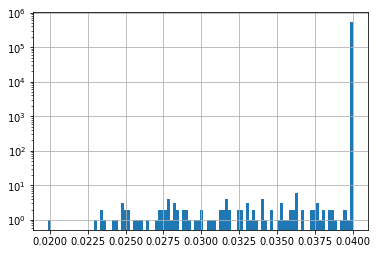

In [29]:
# Distribution of search radius
fig, ax = plt.subplots()
sdss_dr14q_filtered['get_nearby_distance_nb'].hist(bins=100, ax=ax)
ax.set(yscale='log')

# Parsing secondary observations

Query used to find secondary observations:


In [55]:
dtype1 =   {'uid': np.uint32, 'objID'  : np.uint64, 
            'ra' : np.float64, 'ra_ref' : np.float64,
            'dec': np.float64, 'dec_ref': np.float64,
            'get_nearby_distance': np.float64}
dtype2 = {band + 'psf'   : np.float64 for band in 'ugriz'}
dtype3 = {band + 'psferr': np.float64 for band in 'ugriz'}
cols = [ID] + [x for y in zip(['mag_'+b for b in 'griz'], ['magerr_'+b for b in 'griz']) for x in y] + ['mjd_r','get_nearby_distance']


In [59]:
sdss_unmelted = pd.read_csv(path+'data/surveys/sdss/{}/sdss_secondary_unmelted.csv'.format(obj), index_col=ID, usecols=cols, dtype = {**dtype1, **dtype2, **dtype3})

# make observation ID
sdss_unmelted['obsid'] = range(1,len(sdss_unmelted)+1)

# Rename mjd_r to mjd
sdss_unmelted = sdss_unmelted.rename(columns={'mjd_r':'mjd'})

# Add columns for colors
for b1, b2 in zip('gri','riz'):
    sdss_unmelted[b1+'-'+b2] = sdss_unmelted['mag_'+b1] - sdss_unmelted['mag_'+b2]

df_sdss_unpivot1 = pd.melt(sdss_unmelted, id_vars = 'obsid', value_vars = ['mag_'   +b for b in 'griz'], var_name = 'filtercode', value_name = 'mag')
df_sdss_unpivot2 = pd.melt(sdss_unmelted, id_vars = 'obsid', value_vars = ['magerr_'+b for b in 'griz'], var_name = 'filtercode', value_name = 'magerr')

df_sdss_unpivot1['filtercode'] = df_sdss_unpivot1['filtercode'].str[-1]
df_sdss_unpivot2['filtercode'] = df_sdss_unpivot2['filtercode'].str[-1]

sdss_melted = pd.merge(sdss_unmelted.reset_index()[[ID,'obsid','mjd']], pd.merge(df_sdss_unpivot1, pd.merge(df_sdss_unpivot2, sdss_unmelted[['obsid','g-r','r-i','i-z']], on='obsid'), on = ['obsid','filtercode']), on = 'obsid').set_index([ID,'filtercode']).drop('obsid',axis=1)

/disk1/hrb/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


mjd       mag    magerr      g-r      r-i      i-z
uid    filtercode                                                             
1      g           54741.371761  21.90886  0.067707 -0.16113  0.14319  0.55434
       r           54741.371761  22.06999  0.115390 -0.16113  0.14319  0.55434
       i           54741.371761  21.92680  0.148910 -0.16113  0.14319  0.55434
       z           54741.371761  21.37246  0.385455 -0.16113  0.14319  0.55434
2      g           54747.352476  21.61756  0.053961  0.27770  0.05583  0.49685
...                         ...       ...       ...      ...      ...      ...
526356 z           54765.361506  20.60406  0.430547  0.44858  0.40432 -0.32173
       g           55152.207521  21.24377  0.061280  0.55171 -0.10015  1.00635
       r           55152.207521  20.69206  0.051216  0.55171 -0.10015  1.00635
       i           55152.207521  20.79221  0.112842  0.55171 -0.10015  1.00635
       z           55152.207521  19.78586  0.094832  0.55171 -0.10015  1.00635

[5741672 rows x 6 columns]

In [61]:
# Save output from above
sdss_melted.to_csv(path+'data/surveys/sdss/{}/sdss_secondary.csv'.format(obj))

For some reason, our upper search limit is not working when we have nearby objects. Why? Perhaps due to class? SDSS why u no find nearby obj. If it just doesnt work then we will just cut objects with displacement >1"

# Making sure mjd_ugriz does not vary by more than 1 day

In [ ]:
df_ugriz = pd.read_csv(path + 'retrieved_data/dr14q_secondary_mjdfloat_test.csv')
std = df_ugriz[['mjd_' + band for band in 'ugriz']].std(axis=1)
std.nlargest(5)

Observations in different bands are taken within 0.001311 days (2 mins) of eachother. Thus we can take a single band timestamp.

In [ ]:
'{:0.20f}'.format((np.array([54741.371761], dtype = np.float64))[0])